In [145]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

In [94]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [95]:
# LOAD , PROCESS AND GENERATE A TF DATASET FROM DIRECTORY
plt.figure(figsize=(10,10))
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/athulnambiar/Desktop/PROJECTS/POTATO DISEASE/Data',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


<Figure size 1000x1000 with 0 Axes>

In [96]:
# FOLDER NAMES
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [97]:
# LENGTH OF DATASET
# BATCH SIZE = 32 ... 68 BATCHES ... 68*32 = 2176
len(dataset)

68

(32, 256, 256, 3)
[0 1 2 1 1 1 1 0 1 0 0 1 2 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 2 0 0]
tf.Tensor(
[[[163. 156. 163.]
  [163. 156. 163.]
  [150. 143. 150.]
  ...
  [190. 185. 191.]
  [190. 185. 191.]
  [184. 179. 185.]]

 [[105.  98. 105.]
  [168. 161. 168.]
  [140. 133. 140.]
  ...
  [189. 184. 190.]
  [185. 180. 186.]
  [177. 172. 178.]]

 [[181. 174. 181.]
  [128. 121. 128.]
  [173. 166. 173.]
  ...
  [190. 185. 191.]
  [188. 183. 189.]
  [183. 178. 184.]]

 ...

 [[122. 116. 126.]
  [130. 124. 134.]
  [117. 111. 121.]
  ...
  [180. 177. 186.]
  [176. 173. 182.]
  [175. 172. 181.]]

 [[145. 139. 149.]
  [146. 140. 150.]
  [138. 132. 142.]
  ...
  [167. 164. 173.]
  [163. 160. 169.]
  [163. 160. 169.]]

 [[142. 136. 146.]
  [151. 145. 155.]
  [160. 154. 164.]
  ...
  [174. 171. 180.]
  [174. 171. 180.]
  [177. 174. 183.]]], shape=(256, 256, 3), dtype=float32)
(256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[163., 156., 

2024-05-04 21:39:51.473550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


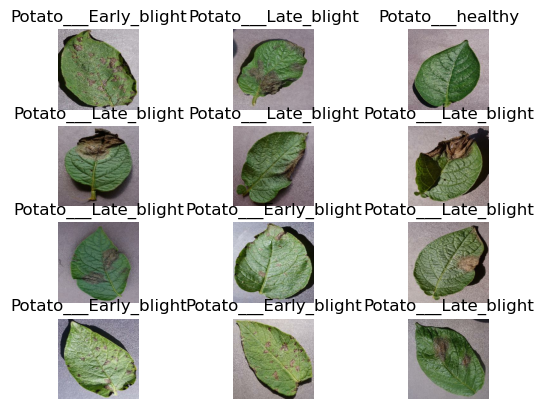

In [98]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        print(image_batch.shape)
        print(label_batch.numpy())
        print(image_batch[i])
        print(image_batch[i].shape)
        print(image_batch[i].numpy)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

### TRAINING AND VALIDATION SPLIT

80% ==> TRAINING
20% ==> 10% VALIDATION, 10% TEST

In [99]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [100]:
train_ds = dataset.take(54)
len(train_ds)

54

In [101]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [102]:
val_size = 0.1
len(dataset)*val_size


6.800000000000001

In [103]:
val_ds =dataset.take(6)
len(val_ds)

6

In [104]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [105]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)


    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds


In [106]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [107]:
len(train_ds)

54

In [108]:
len(val_ds)

6

In [109]:
len(test_ds)

8

In [110]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [111]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
])

In [112]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [113]:
preprocessed_input = tf.keras.Input(shape=(None, None, CHANNELS))  # Allow dynamic image sizes

x = tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)(preprocessed_input)
x = tf.keras.layers.Rescaling(1.0/255)(x)

# Apply data augmentation
augmented = data_augmentation(x)

# Combine preprocessing layers (optional, can be done within model)
combined_preprocess = tf.keras.Model(inputs=preprocessed_input, outputs=augmented)

### MODELM ARCHITECTURE

In [114]:
input_shape = ( BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    combined_preprocess, 
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    # layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [115]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_10 (Functional)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (32, 127, 127, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (32, 62, 62, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (32, 30, 30, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (32, 14, 14, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (32, 6, 6, 64)         │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (32, 2, 2, 64)         │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
model.compile( 
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [117]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    batch_size =BATCH_SIZE,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 608ms/step - accuracy: 0.4339 - loss: 0.9455 - val_accuracy: 0.4948 - val_loss: 0.9374
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.5886 - loss: 0.7658 - val_accuracy: 0.7396 - val_loss: 0.6445
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.7596 - loss: 0.5672 - val_accuracy: 0.8021 - val_loss: 0.5292
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 540ms/step - accuracy: 0.7924 - loss: 0.4611 - val_accuracy: 0.8333 - val_loss: 0.4263
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 525ms/step - accuracy: 0.8662 - loss: 0.3422 - val_accuracy: 0.8542 - val_loss: 0.3549
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - accuracy: 0.8778 - loss: 0.3146 - val_accuracy: 0.8854 - val_loss: 0.2860
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 521ms/step - accuracy: 0.9039 - loss: 0.2470 - val_accuracy: 0.9010 - val_loss: 0.3040
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 524ms/step - accuracy: 0.9101 - loss: 0.2409 - val_accu

In [119]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 1.0000 - loss: 0.0049


In [120]:
scores

[0.004485458601266146, 1.0]

In [121]:
history

In [122]:
history.history

{'accuracy': [0.4739583432674408,
  0.6267361044883728,
  0.7667824029922485,
  0.8049768805503845,
  0.8570601940155029,
  0.8854166865348816,
  0.9027777910232544,
  0.9114583134651184,
  0.9120370149612427,
  0.9265046119689941,
  0.9456018805503845,
  0.9502314925193787,
  0.9415509104728699,
  0.9502314925193787,
  0.9710648059844971,
  0.9427083134651184,
  0.9664351940155029,
  0.9722222089767456,
  0.9774305820465088,
  0.9814814925193787,
  0.9722222089767456,
  0.9809027910232544,
  0.9768518805503845,
  0.9710648059844971,
  0.9895833134651184,
  0.9837962985038757,
  0.9855324029922485,
  0.9803240895271301,
  0.9890046119689941,
  0.9918981194496155,
  0.9878472089767456,
  0.9797453880310059,
  0.9780092835426331,
  0.9866898059844971,
  0.9947916865348816,
  0.9907407164573669,
  0.9913194179534912,
  0.9918981194496155,
  0.9826388955116272,
  0.9942129850387573,
  0.9924768805503845,
  0.9785879850387573,
  0.9901620149612427,
  0.9866898059844971,
  0.9924768805503845

In [123]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [127]:
history_accuracy = history.history['accuracy']
history_val_accuracy = history.history['val_accuracy']
history_loss = history.history['loss']
history_val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

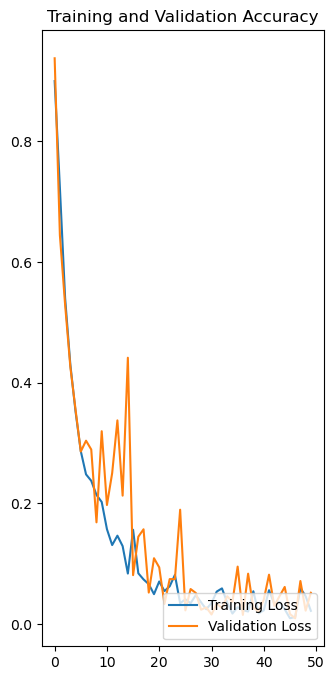

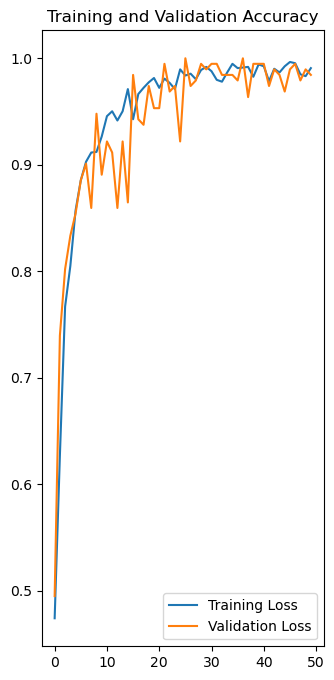

In [128]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),history_loss,label='Training Loss')
plt.plot(range(EPOCHS),history_val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),history_accuracy,label='Training Loss')
plt.plot(range(EPOCHS),history_val_accuracy, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



First Image
Actual Label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Model Prediction: Potato___Early_blight


2024-05-04 22:37:28.195278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


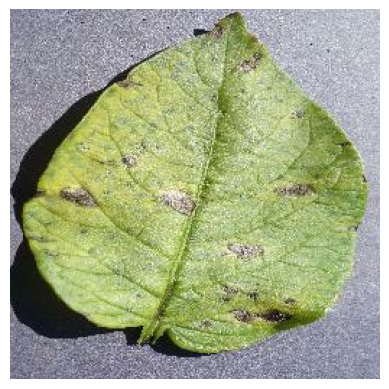

In [142]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    print("First Image")
    plt.imshow(first_image)
    plt.axis('off')
    print("Actual Label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Model Prediction:", class_names[tf.argmax(batch_prediction[0])])

In [143]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2024-05-04 22:44:47.928417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


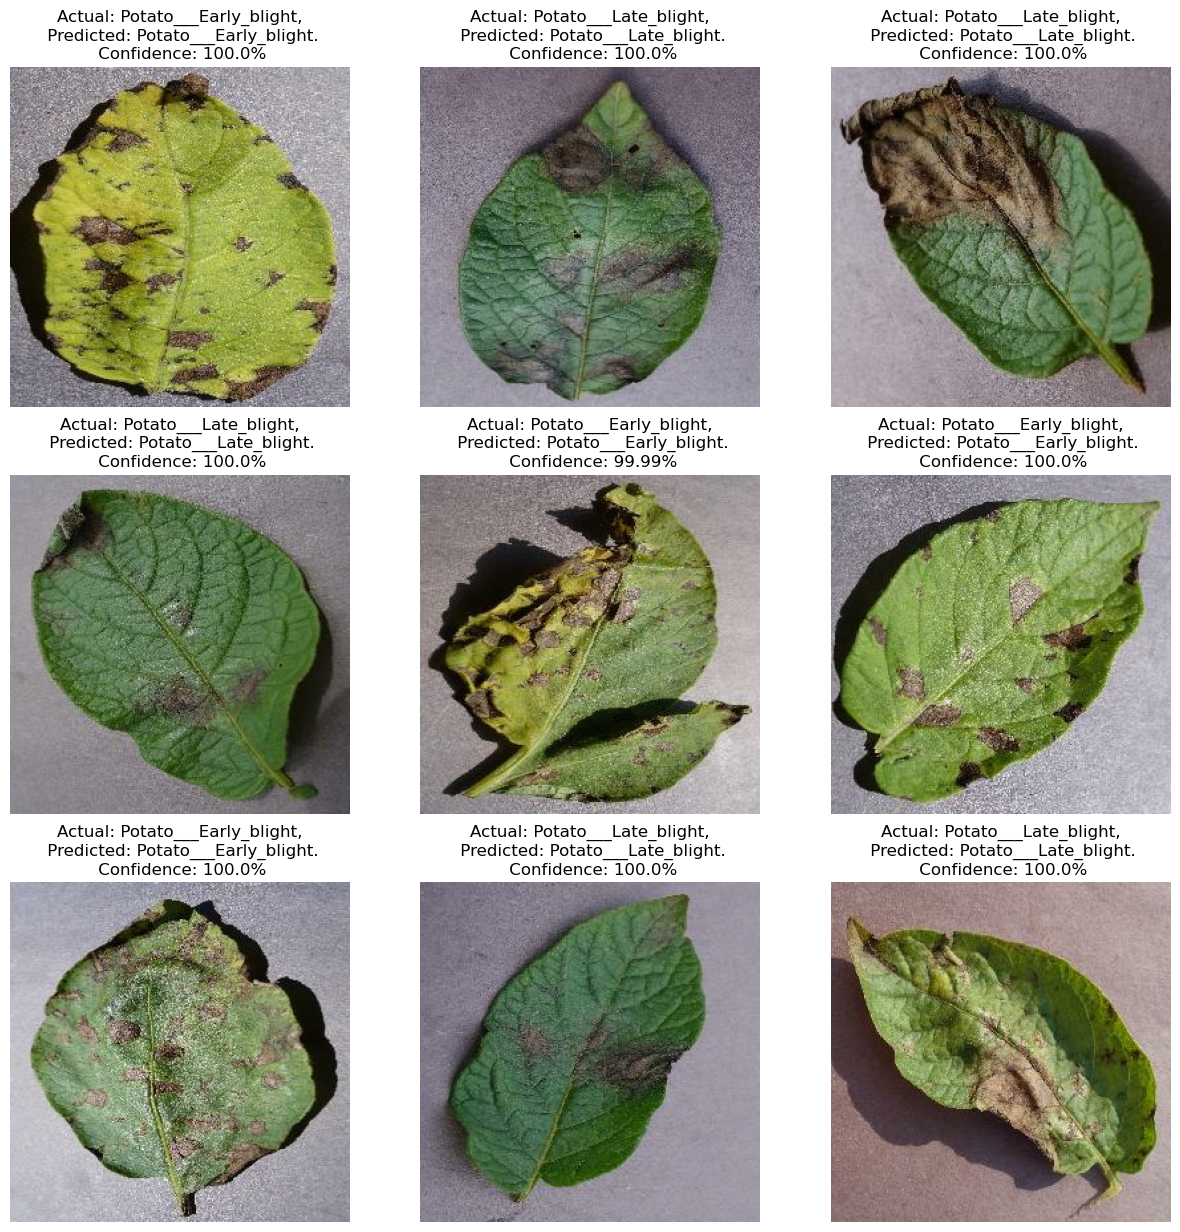

In [146]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [159]:
import os
import tensorflow as tf

model_version = 1
model_path = f"/Users/athulnambiar/Desktop/PROJECTS/POTATO DISEASE/model/model_{model_version}.keras"

# Save the model using tf.keras.models.save_model()
tf.keras.models.save_model(model, model_path)
